### Console

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.1 MB/s eta 0:00:00


In [ ]:
import requests

def download_fasta(ac, output_file):
    url = f"https://www.ebi.ac.uk/ena/browser/api/fasta/{ac}"
    response = requests.get(url)
    if response.status_code == 200:
        with open(output_file, "w") as file:
            file.write(response.text)
        print(f"FASTA file for {ac} saved as {output_file}.")
    else:
        raise Exception(f"Error downloading {ac}: {response.status_code}")

download_fasta("CP015081.1", "file1.fasta")
download_fasta("CP002410.1", "file2.fasta")

FASTA file for CP015081.1 saved as file1.fasta.
FASTA file for CP002410.1 saved as file2.fasta.


In [ ]:
!wget https://github.com/Vladm0z/HSE-Bioinformatics/raw/main/Bioinformatics/MSc/Algorithms/BioAlg_HW1.py

--2025-04-13 10:49:50--  https://github.com/Vladm0z/HSE-Bioinformatics/raw/main/Bioinformatics/MSc/Algorithms/BioAlg_HW1.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Vladm0z/HSE-Bioinformatics/main/Bioinformatics/MSc/Algorithms/BioAlg_HW1.py [following]
--2025-04-13 10:49:50--  https://raw.githubusercontent.com/Vladm0z/HSE-Bioinformatics/main/Bioinformatics/MSc/Algorithms/BioAlg_HW1.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7235 (7.1K) [text/plain]
Saving to: ‘BioAlg_HW1.py’

BioAlg_HW1.py       100%[===================>]   7.07K  --.-KB/s    in 0s      

2025-04-13 10:49:51 (73

In [ ]:
!python BioAlg_HW1.py file1.fasta file2.fasta

Genome 1 length: 2646742
Genome 2 length: 2773157
Chimeric length: 50000
Chimeric error rate: 2.82%
Genome 1 error rate: 0.34%
Genome 2 error rate: 7.77%


### Stats

In [ ]:
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

num1, num2, num3 = [], [], []

n_runs = 1000

for _ in tqdm(range(n_runs), desc="Running experiments"):
    output = subprocess.check_output([
        'python', 'BioAlg_HW1.py', 'file1.fasta', 'file2.fasta'
    ]).decode('utf-8').strip()

    values = [float(v) for v in output.split(', ')]
    num1.append(values[0])
    num2.append(values[1])
    num3.append(values[2])

def get_stats(data):
    return np.mean(data), np.std(data)

Running experiments: 100%|██████████| 1000/1000 [44:00<00:00,  2.64s/it]


In [ ]:
def remove_outliers_iqr(data, threshold=1.5):
    q1, q3 = np.percentile(data, [5, 95])
    iqr = q3 - q1
    lower_bound = q1 - (threshold * iqr)
    upper_bound = q3 + (threshold * iqr)
    return [x for x in data if lower_bound <= x <= upper_bound]

nm1 = remove_outliers_iqr(num1)
nm2 = remove_outliers_iqr(num2)
nm3 = remove_outliers_iqr(num3)

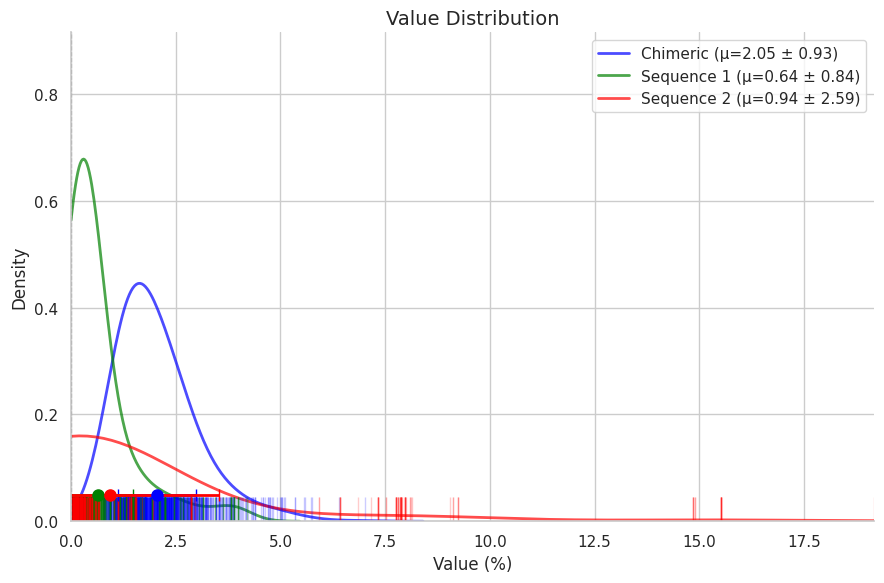

In [ ]:
avg1, err1 = get_stats(nm1)
avg2, err2 = get_stats(nm2)
avg3, err3 = get_stats(nm3)

sns.set(style="whitegrid")
plt.figure(figsize=(9, 6))

# KDE plots with boundary correction
kde_kwargs = {
    'clip': (0, None),  # Prevent negative values
    'bw_method': 0.5,
    'linewidth': 2,
    'alpha': 0.7
}

sns.kdeplot(num1, color='blue', label=f'Chimeric (μ={avg1:.2f} ± {err1:.2f})', **kde_kwargs)
sns.kdeplot(num2, color='green', label=f'Sequence 1 (μ={avg2:.2f} ± {err2:.2f})', **kde_kwargs)
sns.kdeplot(num3, color='red', label=f'Sequence 2 (μ={avg3:.2f} ± {err3:.2f})', **kde_kwargs)

# Rug plots for data density
sns.rugplot(num1, color='blue', height=0.05, alpha=0.2)
sns.rugplot(num2, color='green', height=0.05, alpha=0.2)
sns.rugplot(num3, color='red', height=0.05, alpha=0.2)

# Error bars + mean
for avg, err, color in zip([avg1, avg2, avg3], [err1, err2, err3], ['blue', 'green', 'red']):
    plt.errorbar(avg, 0.05, xerr=err, fmt='o', color=color, markersize=8,
                 ecolor=color, elinewidth=2, capsize=4)

plt.title('Value Distribution', fontsize=14)
plt.xlabel('Value (%)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.xlim(0, max(np.concatenate([nm1, nm2, nm3])))  # Start at 0
plt.legend(frameon=True, loc='upper right')

# 0 line
plt.axvline(0, color='black', linestyle='--', linewidth=0.8, alpha=0.7)

sns.despine()
plt.tight_layout()
plt.savefig("distributions.pdf", bbox_inches='tight', format='pdf')
plt.show()

# Chimeric Sequence HMM Analysis

## Installation of Libraries

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import requests
import math
import matplotlib.pyplot as plt
from Bio import SeqIO
from io import StringIO

## Download genome sequences

In [ ]:
def download_fasta(ac):
    url = f"https://www.ebi.ac.uk/ena/browser/api/fasta/{ac}"
    response = requests.get(url)
    if response.status_code == 200:
        fasta_str = response.text
        fasta_io = StringIO(fasta_str)
        record = list(SeqIO.parse(fasta_io, "fasta"))[0]
        return str(record.seq).upper()
    else:
        raise Exception(f"Error downloading {ac}: {response.status_code}")

In [ ]:
# Deinococcus radiodurans (AC: CP015081.1, ~67.1% GC)
# Clostridium botulinum (AC: CP002410.1, ~28.5% GC)
ac1 = "CP015081.1"
ac2 = "CP002410.1"

seq1 = download_fasta(ac1)
seq2 = download_fasta(ac2)
print(f"Genome 1 length: {len(seq1)}")
print(f"Genome 2 length: {len(seq2)}")

Genome 1 length: 2646742
Genome 2 length: 2773157


## Create a Chimeric Sequence

In [ ]:
def get_random_piece(sequence, avg_length=300):
    # Sample from exp distribution
    piece_length = max(1, int(np.random.exponential(avg_length)))
    max_start = len(sequence) - piece_length
    if max_start < 0:
        return None
    for _ in range(50):
        start = random.randint(0, max_start)
        piece = sequence[start: start+piece_length]
        if all(letter in "ATGC" for letter in piece):
            return piece
    return None

In [ ]:
def build_chimeric_sequence(target_length=50000, avg_length=300):
    chimeric_seq = ""
    true_states = ""
    while len(chimeric_seq) < target_length:
        state = random.choice(['1', '2'])
        if state == '1':
            piece = get_random_piece(seq1, avg_length)
        else:
            piece = get_random_piece(seq2, avg_length)
        if piece is None:
            continue
        chimeric_seq += piece
        true_states += state * len(piece)
    chimeric_seq = chimeric_seq[:target_length]
    true_states = true_states[:target_length]
    return chimeric_seq, true_states

In [ ]:
chimeric_sequence, chimeric_true_states = build_chimeric_sequence(target_length=50000, avg_length=300)
print(f"Chimeric sequence length: {len(chimeric_sequence)}")

Chimeric sequence length: 50000


## Compute Genome Emission Probabilities

In [ ]:
def compute_emission_probs(sequence):
    total = len(sequence)
    count_A = sequence.count("A")
    count_T = sequence.count("T")
    count_G = sequence.count("G")
    count_C = sequence.count("C")
    at_freq = (count_A + count_T) / total
    gc_freq = (count_G + count_C) / total
    probs = {
        "A": at_freq / 2,
        "T": at_freq / 2,
        "G": gc_freq / 2,
        "C": gc_freq / 2,
    }
    return probs

# Emission probabilities
emission_probs_1 = compute_emission_probs(seq1)
emission_probs_2 = compute_emission_probs(seq2)

print("Emission 1:", emission_probs_1)
print("Emission 2:", emission_probs_2)

Emission 1: {'A': 0.164633160315588, 'T': 0.164633160315588, 'G': 0.335366839684412, 'C': 0.335366839684412}
Emission 2: {'A': 0.3575517001020858, 'T': 0.3575517001020858, 'G': 0.1424482998979142, 'C': 0.1424482998979142}


## Define HMM Model and the Viterbi Algorithm

In [ ]:
import math

p_stay = 299 / 300
p_switch = 1 / 300

states = ['1', '2']
transition_probs = {
    '1': {'1': p_stay, '2': p_switch},
    '2': {'1': p_switch, '2': p_stay},
}

start_probs = {
    '1': 0.5,
    '2': 0.5,
}

In [ ]:
def viterbi(obs_seq, states, start_p, trans_p, emis_p_1, emis_p_2):
    n = len(obs_seq)
    V = {}  # V[state][pos] = log probability of path ending with [state] at [pos]
    path = {}

    for state in states:
        emis = emis_p_1 if state == '1' else emis_p_2
        V[state] = [math.log(start_p[state]) + math.log(emis[obs_seq[0]])]
        path[state] = [state]

    for t in range(1, n):
        new_V = {}
        new_path = {}
        symbol = obs_seq[t]
        for curr_state in states:
            emis = emis_p_1 if curr_state == '1' else emis_p_2
            (prob, prev_state) = max(
                (V[prev_state][t-1] + math.log(trans_p[prev_state][curr_state]) + math.log(emis[symbol]), prev_state)
                for prev_state in states
            )
            new_V[curr_state] = V[curr_state] + [prob] if curr_state in V else [prob]
            new_path[curr_state] = path[prev_state] + [curr_state]
        for s in states:
            V[s].append(new_V[s][-1])
            path[s] = new_path[s]

    final_state = max(states, key=lambda s: V[s][-1])
    return "".join(path[final_state])

In [ ]:
def viterbi_decoding(obs_seq, states, start_p, trans_p, emis_p_1, emis_p_2):
    n = len(obs_seq)
    viterbi_mat = {s: [float('-inf')] * n for s in states}
    backpointer = {s: [None] * n for s in states}

    for s in states:
        emis = emis_p_1 if s == '1' else emis_p_2
        viterbi_mat[s][0] = math.log(start_p[s]) + math.log(emis[obs_seq[0]])

    for t in range(1, n):
        symbol = obs_seq[t]
        for s in states:
            emis = emis_p_1 if s == '1' else emis_p_2
            max_tr_prob = float('-inf')
            prev_state_selected = None
            for s_prev in states:
                tr_prob = viterbi_mat[s_prev][t-1] + math.log(trans_p[s_prev][s])
                if tr_prob > max_tr_prob:
                    max_tr_prob = tr_prob
                    prev_state_selected = s_prev
            viterbi_mat[s][t] = max_tr_prob + math.log(emis[symbol])
            backpointer[s][t] = prev_state_selected

    final_state = None
    max_prob = float('-inf')
    for s in states:
        if viterbi_mat[s][-1] > max_prob:
            max_prob = viterbi_mat[s][-1]
            final_state = s

    best_path = [final_state]
    for t in range(n-1, 0, -1):
        best_path.insert(0, backpointer[best_path[0]][t])
    return "".join(best_path)

In [ ]:
def decode_sequence(observed_seq):
    return viterbi_decoding(observed_seq, states, start_probs, transition_probs,
                              emission_probs_1, emission_probs_2)

## Apply HMM to the Sequences and Evaluate

In [ ]:
def calculate_error_rate(true_states, predicted_states):
    errors = sum(1 for t, p in zip(true_states, predicted_states) if t != p)
    return (errors / len(true_states)) * 100

# Сhimeric sequence
predicted_states_chimeric = decode_sequence(chimeric_sequence)
error_chimeric = calculate_error_rate(chimeric_true_states, predicted_states_chimeric)
print(f"Chimeric error rate: {error_chimeric:.2f}%")

with open("predicted_states_chimeric.txt", "w") as f:
    f.write(predicted_states_chimeric)

Chimeric error rate: 1.77%


In [ ]:
def get_clean_segment(sequence, seg_length=50000):
    if len(sequence) < seg_length:
        return None

    max_start = len(sequence) - seg_length
    start_positions = list(range(0, max_start + 1, seg_length // 10))
    random.shuffle(start_positions)

    for start in start_positions:
        seg = sequence[start:start+seg_length]
        if all(letter in "ATGC" for letter in seg):
            return seg

    return None

seg1 = get_clean_segment(seq1, 50000)
seg2 = get_clean_segment(seq2, 50000)

if seg1 is None or seg2 is None:
    raise Exception("Could not find a sufficiently long clean segment in one of the genomes.")

predicted_seg1 = decode_sequence(seg1)
predicted_seg2 = decode_sequence(seg2)

true_seg1 = "1" * len(seg1)
true_seg2 = "2" * len(seg2)

error_seg1 = calculate_error_rate(true_seg1, predicted_seg1)
error_seg2 = calculate_error_rate(true_seg2, predicted_seg2)

print(f"Genome 1 error rate: {error_seg1:.2f}%")
print(f"Genome 2 error rate: {error_seg2:.2f}%")

Genome 1 error rate: 0.36%
Genome 2 error rate: 0.24%


## Visualizations

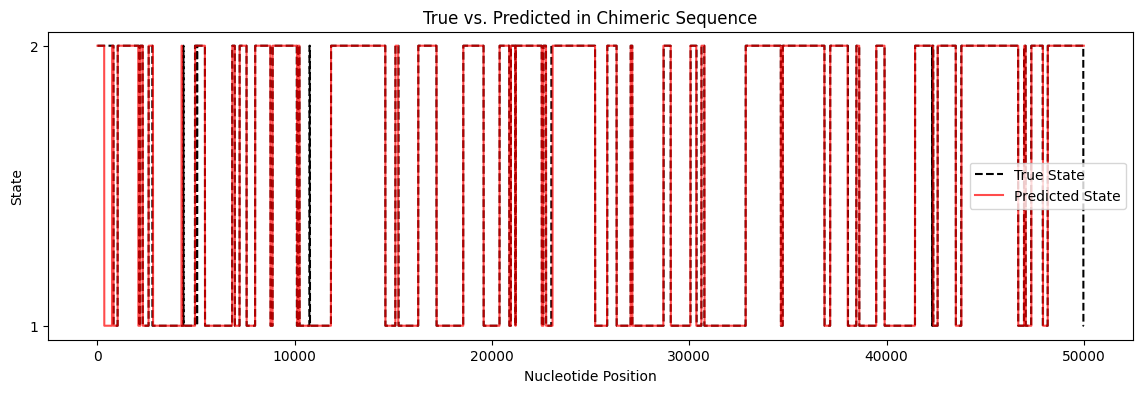

In [ ]:
segment_length = 50000
chimeric_true_seg = chimeric_true_states[:segment_length]
predicted_states_seg = predicted_states_chimeric[:segment_length]
true_numeric = [int(state) for state in chimeric_true_seg]
pred_numeric = [int(state) for state in predicted_states_seg]

plt.figure(figsize=(14, 4))
plt.plot(true_numeric, label="True State", color="black", linestyle="--")
plt.plot(pred_numeric, label="Predicted State", color="red", alpha=0.7)
plt.xlabel("Nucleotide Position")
plt.ylabel("State")
plt.title("True vs. Predicted in Chimeric Sequence")
plt.legend()
plt.yticks([1, 2])
plt.savefig("True&Predicted.pdf", bbox_inches='tight', format='pdf')
plt.show()